In [1]:
from jaxosqp import osqp
import jax
import jax.numpy as jnp
from jax import random

from jax.experimental import sparse

%load_ext autoreload
%autoreload 2

In [9]:
# Generate some random problem data.
from jax.config import config; config.update("jax_enable_x64", False)
B = 50
n = 20
m = 200

outer = lambda A: A @ A.T + 1e-2 * sparse.eye(n)
key = random.PRNGKey(1)
key, subkey = random.split(key)
P = sparse.random_bcoo(key, (B, n, n), nse=0.95, n_batch=1, generator=random.normal).todense()
P = jax.vmap(outer)(P) # Ensure P >= 0.

key, subkey = random.split(key)
q = random.normal(subkey, (B, n))
key, subkey = random.split(key)

# Add some random constraints (a la OSQP benchmarks
A = sparse.random_bcoo(subkey, (B, m, n), nse=0.95, n_batch=1, generator=random.normal).todense()
key, subkey = random.split(key)
l = -random.uniform(subkey, (B, m))
key, subkey = random.split(key)
u = random.uniform(subkey, (B, m))

In [10]:
def solve_osqp(P, q, A, l, u):
    prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
    return jax.vmap(prob.solve)(data, state)

# %timeit sol_mine = solve_osqp(P, q, A, l, u)

# prob, data, state = osqp.OSQPProblem.from_data(
    # P, q, A, l, u)
# sol = jax.vmap(prob.solve)(data, state)
solve_jitd = jax.jit(sparse.sparsify(solve_osqp))#(P, q, A, l, u)
sol = solve_jitd(P, q, A, l, u)
%timeit sol = solve_jitd(P, q, A, l, u)
%timeit sol = solve_jitd(P, q, A, l, u)

108 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
112 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


AttributeError: 'tuple' object has no attribute 'x'

In [470]:
%time solve_osqp(P, q, A, l, u)

CPU times: user 209 ms, sys: 0 ns, total: 209 ms
Wall time: 209 ms


Array([[ 1.38864145e-01,  1.70732021e-01, -2.10882723e-01,
        -2.00839490e-01, -9.35341835e-01,  2.08578989e-01,
         1.92606375e-02,  3.96503538e-01,  2.00927362e-01,
         7.57957622e-02, -8.98166597e-02,  2.51939952e-01,
        -3.11227024e-01,  6.90020770e-02,  2.50960812e-02,
         1.03611052e-01, -2.88685888e-01, -2.51004636e-01,
        -1.39635980e-01,  2.48320192e-01],
       [-3.77256930e-01,  2.43834347e-01, -4.94570434e-02,
         2.16760844e-01,  4.66569886e-02,  2.27107108e-02,
        -1.70008302e-01,  2.50580851e-02, -1.61573857e-01,
        -2.12607995e-01, -8.02972168e-02, -6.36534169e-02,
         1.63530290e-01,  4.94016707e-02, -2.20710650e-01,
        -2.69344568e-01, -4.81215417e-02, -4.17932897e-04,
        -5.91501534e-01, -3.37985128e-01],
       [ 3.31494361e-02,  8.65903199e-02,  1.92397296e-01,
         5.06616607e-02,  5.25929213e-01, -2.05326714e-02,
        -2.41110176e-01,  5.46169639e-01, -9.09369528e-01,
        -3.22042927e-02,  3.5

In [192]:
for ii in range(25):
    state = jax.vmap(prob.step)(data, state)
    state = jax.vmap(prob.update_rho)(data, state)

Traced<ShapedArray(bool[])>with<BatchTrace(level=1/0)> with
  val = Array([ True,  True,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False, False,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True, False, False,  True, False, False,
       False,  True,  True, False,  True, False, False,  True, False,
       False,  True,  True, False,  True, False, False,  True, False,
        True, False, False,  True,  True, False, False,  True,  True,
       False], dtype=bool)
  batch_dim = 0 Traced<ShapedArray(float32[200])>with<BatchTrace(level=1/0)> with
  val = Array([[0.        , 0.        , 0.        , .

In [307]:
# %time sol = jax.vmap(prob.solve)(data, state)
sol_jitd = jax.jit(jax.vmap(prob.solve))
sol_sparse_jitd = jax.jit(jax.vmap(sparse.sparsify(prob.solve)))

sol_jitd(data, state)
sol_sparse_jitd(data, state)

(Array([0, 0, 0, ..., 0, 0, 0], dtype=int32, weak_type=True),
 OSQPData(P=Array([[[ 1.        ,  0.29094326,  0.4284288 , -0.34115893,
          -0.13439813],
         [ 0.29094326,  1.        , -0.37179992,  0.2923568 ,
           0.10243393],
         [ 0.42842877, -0.37179995,  1.        , -0.4718293 ,
           0.53118366],
         [-0.34115896,  0.2923568 , -0.47182932,  0.9999999 ,
           0.2352445 ],
         [-0.13439815,  0.10243393,  0.53118366,  0.2352445 ,
           1.        ]],
 
        [[ 0.9999999 ,  0.31993186,  0.12916589, -0.8673883 ,
           0.00755942],
         [ 0.31993178,  0.5342728 , -0.32173502, -0.43970987,
          -0.03762052],
         [ 0.12916589, -0.3217351 ,  0.6585733 , -0.1761025 ,
          -0.23804316],
         [-0.8673883 , -0.43970987, -0.17610252,  0.9999999 ,
           0.34611914],
         [ 0.00755942, -0.03762053, -0.23804317,  0.34611917,
           0.7202737 ]],
 
        [[ 1.        ,  0.81315273, -0.02081607, -0.696986  ,

In [196]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
%time state = jax.vmap(prob.solve)(data, state)[-1]
%time state = jax.vmap(prob.solve)(data, state)[-1]

CPU times: user 3.81 s, sys: 0 ns, total: 3.81 s
Wall time: 3.81 s
CPU times: user 5.36 s, sys: 16 ms, total: 5.38 s
Wall time: 4.4 s


In [310]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
%time sol_jitd(data, state)
%time sol_sparse_jitd(data, state)

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 120 ms
CPU times: user 118 ms, sys: 27 µs, total: 118 ms
Wall time: 118 ms


(Array([26, 26, 26, ..., 26, 51, 26], dtype=int32, weak_type=True),
 OSQPData(P=Array([[[ 1.        ,  0.29094326,  0.4284288 , -0.34115893,
          -0.13439813],
         [ 0.29094326,  1.        , -0.37179992,  0.2923568 ,
           0.10243393],
         [ 0.42842877, -0.37179995,  1.        , -0.4718293 ,
           0.53118366],
         [-0.34115896,  0.2923568 , -0.47182932,  0.9999999 ,
           0.2352445 ],
         [-0.13439815,  0.10243393,  0.53118366,  0.2352445 ,
           1.        ]],
 
        [[ 0.9999999 ,  0.31993186,  0.12916589, -0.8673883 ,
           0.00755942],
         [ 0.31993178,  0.5342728 , -0.32173502, -0.43970987,
          -0.03762052],
         [ 0.12916589, -0.3217351 ,  0.6585733 , -0.1761025 ,
          -0.23804316],
         [-0.8673883 , -0.43970987, -0.17610252,  0.9999999 ,
           0.34611914],
         [ 0.00755942, -0.03762053, -0.23804317,  0.34611917,
           0.7202737 ]],
 
        [[ 1.        ,  0.81315273, -0.02081607, -0.696

Text(0, 0.5, 'solve time (batch of 100), ms')

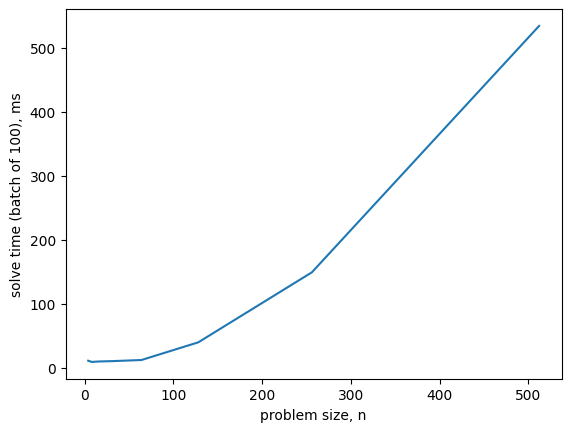

In [280]:
n_vals = [4, 8, 16, 32, 64, 128, 256, 512]
times = [10.9, 9.01, 9.7, 10.3, 12, 39.6, 149, 534]

from matplotlib import pyplot as plt

plt.plot(n_vals, times)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('problem size, n')
plt.ylabel('solve time (batch of 100), ms')

In [4]:
with jax.profiler.trace("/tmp/tensorboard"):
    prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
    sol_mine = jax.vmap(prob.solve)(data, state)

In [8]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [77]:
from matplotlib import pyplot as plt

plt.hist(sol[0], bins=8)
plt.title(f'Histogram of solve times, n={n}, B={B}, m={m}')
plt.xlabel('Number of iterations')
plt.ylabel('Freq')

TypeError: 'OSQPState' object is not subscriptable

In [162]:
A = sparse.random_bcoo(key, (5, 2, 2), nse=0.15, n_batch=1, generator=random.normal)
sum_x = jax.vmap(sparse.sparsify(lambda x: jnp.sum(x @ x.T + sparse.eye(2))))

sum_x(A)

Array([2.005999 , 2.1144671, 2.004582 , 2.5526845, 2.1723697], dtype=float32)

In [58]:
import jax_dataclasses as jdc

@jdc.pytree_dataclass
class Foo:
    x: jnp.ndarray
    y: jnp.ndarray
    z: jdc.Static[int]
    
def sumup(foo):
    return foo.x + foo.y

bar = Foo(jnp.ones((2, 5)), jnp.ones((2, 5)), 3)
jax.vmap(sumup)(bar)

Array([[2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.]], dtype=float32)

In [359]:
# A_sparse = sparse.random_bcoo(subkey, (B, m, n), nse=0.01, n_batch=1, generator=random.normal)
# A = A_sparse.todense()

A_sparse = sparse.random_bcoo(subkey, (B, m, n), nse=0.01, n_batch=1, generator=random.normal)
A_sparse = sparse.BCSR.from_bcoo(A_sparse)

A = A_sparse.todense()

matmul_jit = jax.jit(sparse.sparsify(lambda A, x: A@x))

state = sol[-1]

jax.vmap(matmul_jit)(A_sparse, state.x)
jax.vmap(matmul_jit)(A, state.x)

%timeit jax.vmap(matmul_jit)(A_sparse, state.x)
%timeit jax.vmap(matmul_jit)(A, state.x)




# # Define jit'd matrix-vector product (vmap across batch dim)
# bmm = jax.jit(jax.vmap(sparse.sparsify(lambda A, x: A @ x)))

# # Run it once to compile
# bmm(A, state.x)
# bmm(A_sparse, state.x)

# # Time dense / sparse naive calls
# %timeit bmm(A, state.x) # 23.1 µs ± 1.59 µs per loop
# %timeit bmm(A_sparse, state.x) # 32.6 µs ± 2.2 µs per loop

# jit a low-level matmul
# bmm_sp = lambda A, x: sparse.bcoo_dot_general(A, x, dimension_numbers=((2, 1), (0,0)))
# jitbmmsp = jax.jit(bmm_sp) 

# jitbmmsp(A_sparse, state.x) # Run to compile
# %timeit jitbmmsp(A_sparse, state.x) # 30.1 µs ± 2.02 µs per loop

1.06 ms ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
450 µs ± 4.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [109]:
A_sparse.shape

(10, 1000, 100)

In [182]:
times

NameError: name 'times' is not defined

In [11]:
import osqp as oo
import numpy as np
import scipy 

B, m, n = A.shape

results = []
probs = []

def setup_all(probs):
    for ii in range(B):
        m = oo.OSQP()
        m.setup(
            P=scipy.sparse.csc_matrix(np.asarray(P[ii, :, :])), 
            q=np.asarray(q[ii,:]), 
            A=scipy.sparse.csc_matrix(np.asarray(A[ii, :, :])), 
            l=np.asarray(l[ii, :]), 
            u=np.asarray(u[ii,:]), 
            verbose=False, 
            adaptive_rho=False,
            scaling=10,
            max_iter=4000)
            # linsys_solver='mkl paradiso')
        probs.append(m)
        
def solve_all(probs, results):
    solve_time = 0.
    for m in probs:
        results.append(m.solve())
        solve_time += results[-1].info.setup_time + results[-1].info.solve_time
        
    return solve_time

setup_all(probs)
%time solve_time = solve_all(probs, results)
osqp_iters = [rr.info.iter for rr in results]

1000 * solve_time

CPU times: user 30.4 ms, sys: 0 ns, total: 30.4 ms
Wall time: 30.4 ms


52.223549999999996

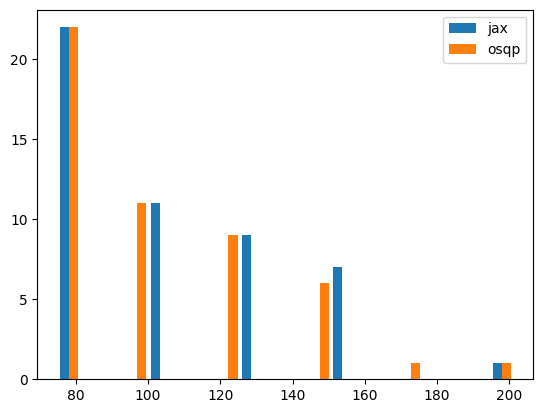

In [12]:
from matplotlib import pyplot as plt

plt.close("all")
fig, ax = plt.subplots()
ax.hist([sol[0], osqp_iters], label=['jax', 'osqp'], bins=20)
# ax.hist(, bins=10, range=(0, max(sol[0])), label='osqp', alpha=0.5)
ax.legend()

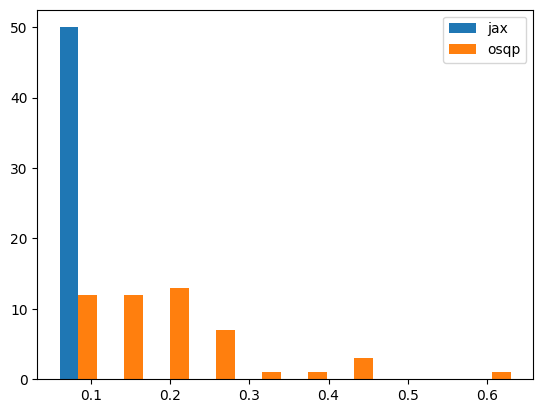

In [158]:
plt.close("all")
fig, ax = plt.subplots()

ax.hist([sol[-1].rho[:, 0], [rr.info.rho_estimate for rr in results]], label=['jax', 'osqp'])
ax.legend()

In [39]:
from jaxopt import BoxOSQP

qp = BoxOSQP(jit=True)
solve_qp = jax.jit(jax.vmap(lambda P, q, A, l, u: qp.run(params_obj=(P, q), params_eq=A, params_ineq=(l,u)).params))

sol = solve_qp(P, q, A, l, u)
%timeit sol = solve_qp(P, q, A, l, u)

sol_mine[-1].x - sol.primal[0]

3.34 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'sol_mine' is not defined

In [290]:
osqp_iters = jnp.array(osqp_iters)
my_iters = sol[0]

print(f"osqp stats | mean: {jnp.mean(osqp_iters)}, median: {jnp.median(osqp_iters)}, std: {jnp.std(osqp_iters)}, max: {jnp.max(osqp_iters)}")
print(f"my stats | mean: {jnp.mean(my_iters)}, median: {jnp.median(my_iters)}, std: {jnp.std(my_iters)}, max: {jnp.max(my_iters)}")

osqp stats | mean: 33.30000305175781, median: 25.0, std: 20.520965576171875, max: 325
my stats | mean: 32.10000228881836, median: 26.0, std: 14.063783645629883, max: 201


In [291]:
results[0].x, sol[-1].x[0], results[0].info.iter

(array([-0.48711722,  0.05135288]),
 Array([-0.4871236 ,  0.05135123], dtype=float32),
 75)

In [251]:
# Bug hunting
P = jnp.array([[[0.61585732]]])
q = jnp.array([[0.1930774]])
A = jnp.array([[[0.00870719]]])
l = jnp.array([[-0.1864503]])
u = jnp.array([[0.88669298]])

prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
%time sol = jax.vmap(prob.solve)(data, state)
sol[-1].z

jax_obj = 0.5 * jnp.dot(sol[-1].x[0], P[0] @ sol[-1].x[0]) + jnp.dot(q[0], sol[-1].x[0])
# osqp_obj = 0.5 * np.dot(results[0].x, P[0] @ results[0].x) + np.dot(q[0], results[0].x)

sol[-1].rho

CPU times: user 572 ms, sys: 11.5 ms, total: 583 ms
Wall time: 588 ms


Array([[0.1]], dtype=float32, weak_type=True)

In [308]:
sol[0], osqp_iters

(Array([26, 26, 26, 26, 26, 51, 26, 26, 26, 26, 26, 51, 26, 26, 26, 26, 26,
        26, 51, 26, 26, 26, 26, 51, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 51, 26, 26, 26, 26, 26, 26, 26, 26, 26, 51, 26, 26,
        26, 51, 51, 51, 26, 26, 26, 26, 26, 26, 26, 51, 26, 26, 26, 26, 26,
        51, 51, 51, 26, 26, 26, 26, 51, 51, 26, 51, 26, 26, 51, 26, 51, 26,
        26, 26, 26, 51, 26, 26, 51, 26, 51, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 51, 26, 51, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 51, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 51, 51, 26, 26, 26, 26, 26, 26, 51, 26, 26, 26, 26, 26, 51,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 76, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 51, 26, 26, 51, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 51, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 51,
        26, 26, 26, 26, 26, 26, 51, 26, 26, 26, 26, 26, 51, 26, 51, 26, 26,
        26, 

In [159]:
# Comparing how the solutions diverge
prob, data, state_scaled = osqp.OSQPProblem.from_data(P, q, A, l, u, config=osqp.OSQPConfig(max_iters=1))

results = []
T = 250
div_x = jnp.zeros((B, T))
div_y = jnp.zeros((B, T))
# [mm.update_settings(verbose=True) for mm in probs]
for ii in range(T):
    probs = []
    setup_all(probs)
    results = []
    [mm.update_settings(max_iter=ii+1) for mm in probs]
#         for jj in range(B):
#             probs[jj].warm_start(x=np.asarray(state.x[jj]), y=np.asarray(state.y[jj]))
        
    state_scaled = jax.vmap(prob.step)(data, state_scaled)
    state = jax.vmap(prob.unscale_vars)(data, state_scaled)
    solve_all(probs, results)
    for jj in range(B):
        error = jnp.linalg.norm(state.x[jj] - results[jj].x)
        y_error = jnp.linalg.norm(state.y[jj] - results[jj].y)
        div_x = div_x.at[jj, ii].set(error)
        div_y = div_y.at[jj, ii].set(y_error)

KeyboardInterrupt: 

Text(0.5, 1.0, 'parameter differences jax vx. OSQP')

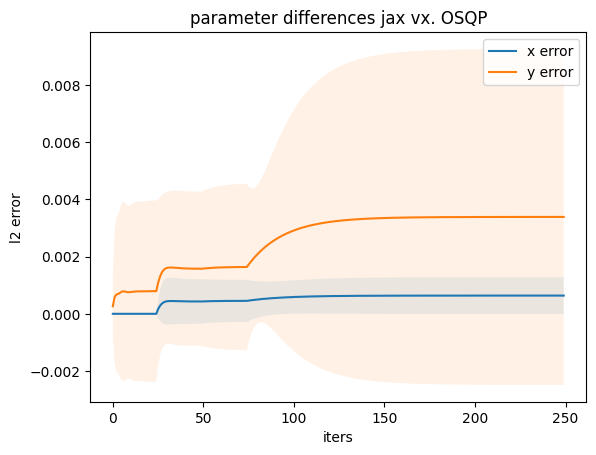

In [143]:
from matplotlib import pyplot as plt
plt.close("all")
fig, ax = plt.subplots()
divx_mean = jnp.mean(div_x, axis=0)
divx_std = jnp.std(div_x, axis=0)
divy_mean = jnp.mean(div_y, axis=0)
divy_std = jnp.std(div_y, axis=0)
ax.plot(jnp.arange(len(divx_mean)), divx_mean, label='x error')
ax.fill_between(jnp.arange(len(divx_mean)), divx_mean - 2 * divx_std, divx_mean + 2 * divx_std, alpha=0.1)
ax.plot(jnp.arange(len(divy_mean)), divy_mean, label='y error')
ax.fill_between(jnp.arange(len(divy_mean)), divy_mean - 2 * divy_std, divy_mean + 2 * divy_std, alpha=0.1)
ax.legend()
ax.set_xlabel('iters')
ax.set_ylabel('l2 error')
ax.set_title('parameter differences jax vx. OSQP')

In [309]:
[rr.info.iter for rr in results], state.converged

([25,
  25,
  25,
  25,
  50,
  50,
  50,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  50,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  50,
  50,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  50,
  50,
  50,
  25,
  25,
  25,
  25,
  50,
  50,
  25,
  50,
  50,
  25,
  50,
  25,
  50,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  50,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  25,
  50,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  50,
  50,
  25,
  25,
  25,
  25,
  50,
  25,
  25,
  50,
  25,
  25,
  25,
  25,
  25,
  25,
  25,
  100,
  25,
  25,
  2

In [151]:
sol

(Array([51, 26, 76, 26, 26], dtype=int64, weak_type=True),
 OSQPData(P=Array([[[ 1.        ,  0.04953851,  0.14390485, ..., -0.09622749,
          -0.02397834,  0.36724911],
         [ 0.04953851,  1.        , -0.09837497, ..., -0.26287997,
          -0.0879546 , -0.30567721],
         [ 0.14390485, -0.09837497,  1.        , ...,  0.1008785 ,
           0.59088617,  0.18411601],
         ...,
         [-0.09622749, -0.26287997,  0.1008785 , ...,  1.        ,
          -0.15360153,  0.20523239],
         [-0.02397834, -0.0879546 ,  0.59088617, ..., -0.15360153,
           1.        , -0.25783934],
         [ 0.36724911, -0.30567721,  0.18411601, ...,  0.20523239,
          -0.25783934,  1.        ]],
 
        [[ 1.        , -0.25564654,  0.13749279, ..., -0.14170522,
          -0.16413242, -0.38841411],
         [-0.25564654,  1.        , -0.20499922, ...,  0.40492141,
          -0.00808829, -0.21062601],
         [ 0.13749279, -0.20499922,  1.        , ...,  0.39414183,
           0.0

In [311]:
jnp.all(sol[-1].converged)

Array(True, dtype=bool)